# Exercise 6: Clustering

In this assignment you will experiment with k-means as an image compression algorithm.

## Read the following instructions carefully:

1. Unlike previous notebooks, most of this exercise will be graded automatically. Your will write **all** of your core functions in a script named `src/hw6.py` and it will be tested automatically. This jupyter notebook contains the instructions for the exercise, visualizations and qualitative questions that should be answered in the notebook itself. Note that you are allowed to use the notebook for any tests you want to run.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in `src/hw6.py` only. **Do not create additional Python modules**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook and the `src/hw6.py` file only. Use **ZIP** and name the file using your ID. For example: `hw6_123456789_987654321.zip` if you submitted in pairs and `hw6_123456789.zip` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support) within this notebook. **Answers that will be written in commented code blocks will not be checked.**

## Color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

You might need to install skimage using `conda install -c conda-forge scikit-image`.

Also, note that `numpy.power()` is a slow function! https://stackoverflow.com/questions/25254541/why-is-numpy-power-60x-slower-than-in-lining

In [1]:
# this will reload the python modules automatically
# so changes you make in the hw6.py script will be updated
# automatically within this notebook
%load_ext autoreload
%autoreload 2

import numpy as np
from skimage import io
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

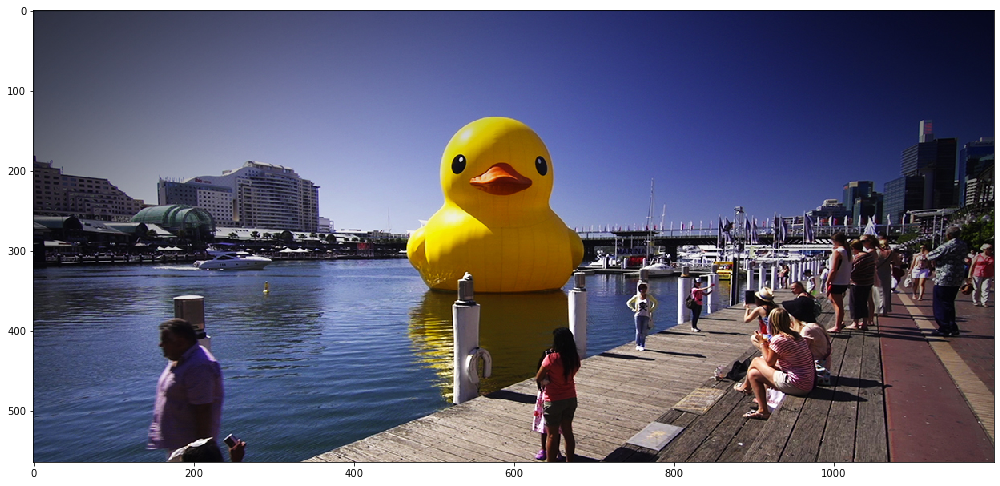

(564, 1200, 3)


In [2]:
# load the image and confirm skimage is imported properly.
image = io.imread('data/small_duck.jpg')
io.imshow(image)
io.show()
print(image.shape)

This single image has over 2 million values. Make sure your code is vectorized and efficient!

In [3]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
print(image.shape)

(676800, 3)


## Random centroids (15 points)

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.

Open the file `src/hw6.py` and complete the function `get_random_centroids`.

This function should take as input a single image of shape `(num_pixels, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimensional array for easier manipulation. This function should return randomly chosen centroids of shape `(k,3)` as a numpy array. Make sure you are choosing different values.

In [4]:
import numpy as np

def get_random_centroids(X, k):

    '''
    Each centroid is a point in RGB space (color) in the image. 
    This function should uniformly pick `k` centroids from the dataset.
    Input: a single image of shape `(num_pixels, 3)` and `k`, the number of centroids. 
    Notice we are flattening the image to a two dimentional array.
    Output: Randomly chosen centroids of shape `(k,3)` as a numpy array. 
    '''
    
    centroids = []
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    if (k == 0):
        return centroids
    
    data_size = X.shape[0]
    k_size = int(data_size/k)
    rng = np.random.default_rng() #new generator for random values

    centroids = [rng.choice(X[i*k_size:(i+1)*k_size]) for i in range(k)] #creates the random centroids
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    # make sure you return a numpy array
    return np.asarray(centroids).astype(np.float)  

In [5]:
k = 7 
centroids = get_random_centroids(image, k)

## Distance function (25 points)

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Open the file `src/hw6.py` and complete the function `lp_distance`.

Inputs: 
* a single image of shape `(num_pixels, 3)`.
* the centroids `(k, 3)`.
* the distance parameter p.

Output: numpy array of shape `(k, num_pixels)` thats holds the distances of all points in RGB space from all centroids.

In [6]:
def lp_distance(X, centroids, p=2):

    '''
    Inputs: 
    A single image of shape (num_pixels, 3)
    The centroids (k, 3)
    The distance parameter p

    output: numpy array of shape `(k, num_pixels)` thats holds the distances of 
    all points in RGB space from all centroids
    '''
    distances = []
    k = len(centroids)
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
        
    for i in range(k):
        current = ((np.abs(X-centroids[i]))**p).sum(axis=1)**(1/p)
        distances.append(current)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return distances

In [7]:
distances = lp_distance(image, centroids, 5)
#distances

[array([2.        , 2.93015605, 2.45401945, ..., 3.38436032, 3.03143313,
        3.50899158]),
 array([3.05245433, 3.17963063, 3.58962641, ..., 3.24714319, 3.21409585,
        3.32923661]),
 array([2.08071655, 3.44751205, 2.95154632, ..., 3.27194695, 2.31854196,
        2.8766912 ]),
 array([3.51425246, 3.45456223, 3.32269903, ..., 3.47674423, 2.86193816,
        2.        ]),
 array([2.74903286, 1.        , 2.96201306, ..., 1.        , 3.66693073,
        3.40988855]),
 array([2.52678008, 3.63312836, 3.28750366, ..., 3.49435919, 3.00492209,
        2.78319281]),
 array([2.37773099, 3.05014711, 2.93286415, ..., 2.93015605, 2.63901582,
        2.49146188])]

## Kmeans algorithm (40 points)

Calculate the locally optimal centroids as learned in class. At each iteration, assign every RGB point to its closest centroid and calculate new centroids by averaging the points that were assigned to every centroid. This function stops, when no improvement was made or once max_iter iterations is reached.

A reasonable implementation runs on a Core i7 CPU in less than a minute with `k=16`.

Open the file `src/hw6.py` and complete the function `kmeans`.

Inputs:
- X: a single image of shape (num_pixels, 3).
- k: number of centroids.
- p: the parameter governing the distance measure.
- max_iter: the maximum number of iterations to perform. (default value = 100).

Outputs:
- The calculated centroids as a numpy array.
- The final assignment of all RGB points to the closest centroids as a numpy array.
"""


In [8]:
def update_centroids_mean(X, classes, centroids):
    new_centroids = []
    n_centroids = len(centroids)
    
    #creating new centroids based on the average
    for i in range(n_centroids):
        new_centroids.append(np.average(X, weights=(classes == i), axis=0))
        
    return np.array(new_centroids)

In [9]:
def kmeans_with_existing_centroids (centroids, classes, X, k, p, max_iter=100):
    for i in range(max_iter):
        distances = lp_distance(X, centroids, p)
        
        classes = np.argmin(distances, axis=0) # update classes to be the min
        
        prev_centroids = centroids
        centroids = update_centroids_mean(X, classes, centroids) # update centroids
        # two different stop condition:
        # one for checking that there is no change at all- if we prefer precision
        # if((centroids == prev_centroids).all()):
        # two for checking difference up to an epsilon- if we prefer lower time complexity
        if np.allclose(centroids, prev_centroids, rtol=0, atol=1):
            break
    return centroids, classes

In [10]:
def kmeans(X, k, p ,max_iter=100):
    """
    Inputs:
    - X: a single image of shape (num_pixels, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.

    Outputs:
    - The calculated centroids as a numpy array.
    - The final assignment of all RGB points to the closest centroids as a numpy array.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    classes0 = [0]*(X.shape[0])
    centroids0 = np.array(get_random_centroids(X,k))
    
    centroids, classes = kmeans_with_existing_centroids (centroids0, classes0, X, k, p, max_iter)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return centroids, classes


In [11]:
%%time
centroids, classes = kmeans(image, k=16, p=1, max_iter=100) #was 4 but changed to 16 to see if less than a minute

CPU times: user 14.3 s, sys: 180 ms, total: 14.4 s
Wall time: 14.4 s


We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with a centroid. The following cell does that for you.

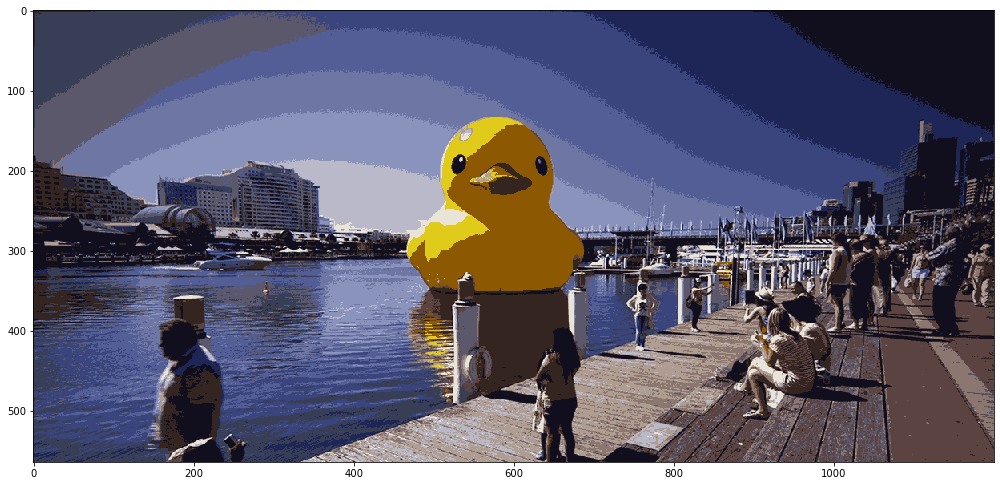

In [12]:
classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0], classes.shape[1],3), dtype=np.uint8)
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
io.imshow(compressed_image)
io.show()

## Kmeans++ (20 points)


Open the file `src/hw6.py` and complete the function `kmeans_pp`. 

kmeans++ is an algorithm for choosing the initial centroids for the k-means clustering algorithm.

The idea is as follows:

1. Choose a centroid uniformly at random among the data points.
2. For each data points not chosen yet, compute the distance between the data point and the single nearest centroid that had already been chosen.
3. Choose one new data point at random as a new centroid, using a weighted probability distribution where a data point is chosen with probability proportional to the square of the distance you calculated previously. For each data point, the weight will be equal to the square distance to the closest center divided by the total squared distance (to make sure the probability adds up to 1).
4. Repeat Steps 2 and 3 until k centroids have been chosen.
5. Now that the initial centroids have been chosen, proceed using standard k-means clustering.

Inputs:
- X: a single image of shape (num_pixels, 3).
- k: number of centroids.
- p: the parameter governing the distance measure.
- max_iter: the maximum number of iterations to perform. (default value = 100).

Outputs:
- The calculated centroids as a numpy array.
- The final assignment of all RGB points to the closest centroids as a numpy array.
"""

Run each algorithm (kmeans, kmeans++) 10 times and visualize the performance differences. Note, `kmeans_pp` should be implemented in the file `src/hw6.py`, but the visualization can either by implemented in the file `src/hw6.py` or in the notebook itself. Explain your results in a markdown cell.

In [13]:
def kmeans_pp(X, k, p ,max_iter=100):
    """
    Your implenentation of the kmeans++ algorithm.
    Inputs:
    - X: a single image of shape (num_pixels, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.

    Outputs:
    - The calculated centroids as a numpy array.
    - The final assignment of all RGB points to the closest centroids as a numpy array.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    classes0 = [0]*(X.shape[0])
    centroids0 = []
    #initializing first centroid randomly
    centroids0.append(X[np.random.randint(X.shape[0]), :])
    
    #handling the next k-1 centroids
    for centroid_i in range(k - 1):
        # initialize a list to store distances of data points from nearest centroid
        distances = lp_distance(X, centroids0, p)
        closest_centroid_distances = (np.amin(distances, axis=0))**2
        probabilities = (closest_centroid_distances / np.sum(closest_centroid_distances))
        rng = np.random.default_rng() #new generator for random values
        centroid_i_index =rng.choice(X.shape[0], p=probabilities)
        centroid_i = X[centroid_i_index]
        centroids0.append(centroid_i)
    
    centroids0 = np.array(centroids0)
    centroids, classes = kmeans_with_existing_centroids (centroids0, classes0, X, k, p, max_iter)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return centroids, classes

In [14]:
%%time
centroids, classes = kmeans_pp(image, k=16, p=1, max_iter=100)

CPU times: user 10.4 s, sys: 71.7 ms, total: 10.5 s
Wall time: 10.5 s


Again, we can visualize the resulted image.

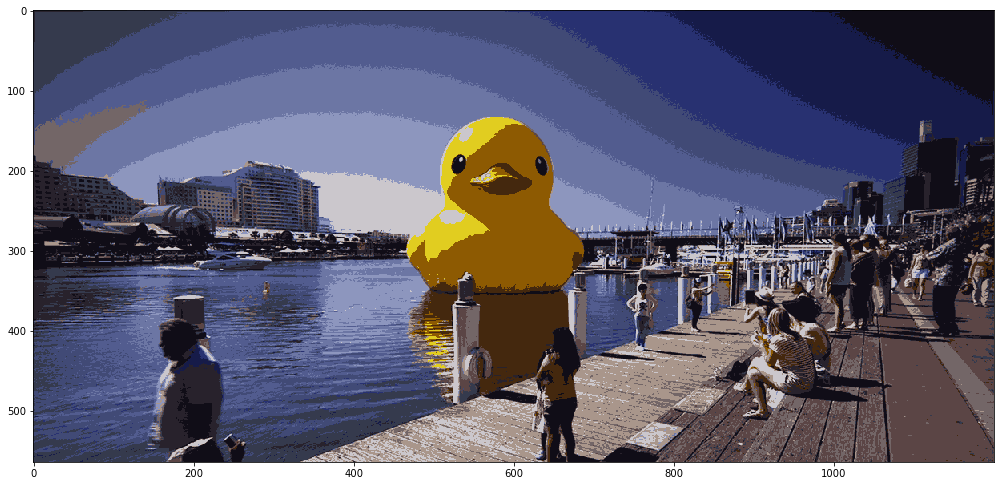

In [15]:
classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0], classes.shape[1],3), dtype=np.uint8)
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
io.imshow(compressed_image)
io.show()

Don't forget to compare the results of kmeans with the improved kmeans++ and to explain your results in a markdown cell.

In [16]:
def inertia_calc (X, centroids, p=2):
    distances = lp_distance(X, centroids, p)
    closest_centroid_distances = np.amin(distances, axis=0)
    return np.sum((closest_centroid_distances)**2)

In [17]:
%%time
#we check the inertia for each 10 different k ranging from 2 to 20 (only even numbers)
inertias_kmeans = []
inertias_kmeans_pp = []

for k in range(2, 21, 2):
    centroids_pp, classes_pp = kmeans_pp(image, k=k, p=2, max_iter=100)
    centroids, classes = kmeans(image, k=k, p=2, max_iter=100)
    inertias_kmeans_pp.append(inertia_calc(image, centroids_pp, p=2))
    inertias_kmeans.append(inertia_calc(image, centroids, p=2))
    
# print (inertias_kmeans)
# print ()
# print (inertias_kmeans_pp)

CPU times: user 3min 30s, sys: 1.85 s, total: 3min 32s
Wall time: 3min 33s


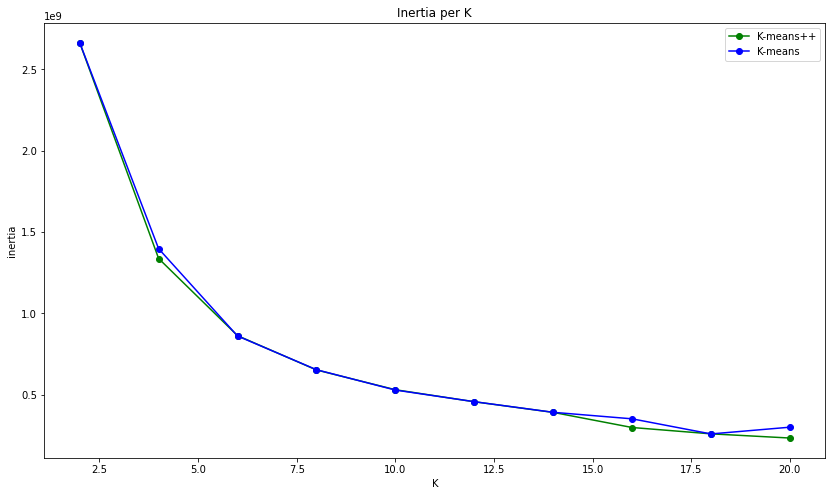

In [18]:
plt.plot(np.arange(2, 21, 2), inertias_kmeans_pp, label='K-means++', marker = 'o', color='red')
plt.plot(np.arange(2, 21, 2), inertias_kmeans, marker = 'o', label='K-means', color='blue')
plt.xlabel('K')
plt.ylabel('inertia')
plt.title("Inertia per K")
plt.legend()
plt.show()

Your explanation here

### As we can see the difference between the inertia of the kmeans and the kmeans++ algorithms is not significant, therefore we will try a different comparison method- comparing the std and mean of the inertia instead, for a fixed k=2, 4, 8, 16.

In [25]:
%%time
#we check the mean and std for k=16 for 10 iterations
inertias_kmeans_pp1 = []
inertias_kmeans1 = []
inertias_std_kmeans = []
inertias_std_kmeans_pp = []
inertias_mean_kmeans = []
inertias_mean_kmeans_pp = []

k_options = [2,4,8,16]
for i in (k_options):
    inertias_kmeans_pp1 = []
    inertias_kmeans1 = []
    for j in range (10):
        # for each k calculate the inertia in 10 different runs and append it
        centroids_pp, classes_pp = kmeans_pp(image, k=k, p=2, max_iter=100)
        centroids, classes = kmeans(image, k=k, p=2, max_iter=100)
        inertias_kmeans_pp1.append(inertia_calc(image, centroids_pp, p=2))
        inertias_kmeans1.append(inertia_calc(image, centroids, p=2))
    # append the std and mean of the 10 runs for each k
    inertias_std_kmeans_pp.append (np.std(np.array(inertias_kmeans_pp1)))
    inertias_std_kmeans.append (np.std(np.array(inertias_kmeans1)))
    inertias_mean_kmeans_pp.append (np.mean(np.array(inertias_kmeans_pp1)))
    inertias_mean_kmeans.append (np.mean(np.array(inertias_kmeans1)))

    
print (inertias_kmeans)
print ()
print (inertias_kmeans_pp)

[2664050138.3137426, 1397203143.1942065, 860308768.9834732, 652926717.5590858, 527885239.9516094, 456255295.05126685, 390986280.82246953, 350877945.4364413, 257958507.17726716, 299420621.30157995]

[2664076682.270841, 1336811447.5754135, 862359568.4034045, 651543309.5775484, 529812241.58253604, 455861810.00098383, 390515612.9540674, 297511501.6802696, 258512842.03363445, 232749323.8245701]
CPU times: user 39min 43s, sys: 36.6 s, total: 40min 20s
Wall time: 41min 33s


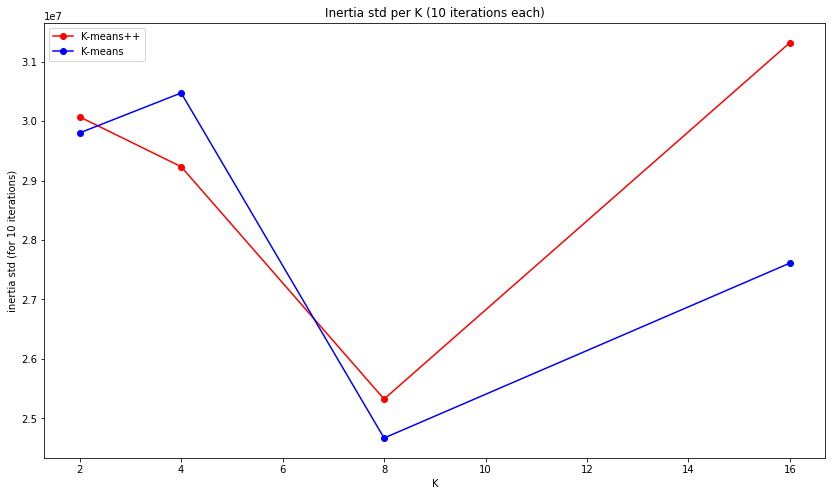

In [30]:
plt.plot(np.array ([2,4,8,16]), inertias_std_kmeans_pp, label='K-means++', marker = 'o', color='red')
plt.plot(np.array ([2,4,8,16]), inertias_std_kmeans, marker = 'o', label='K-means', color='blue')
plt.xlabel('K')
plt.ylabel('inertia std (for 10 iterations)')
plt.title("Inertia std per K (10 iterations each)")
plt.legend()
plt.show()

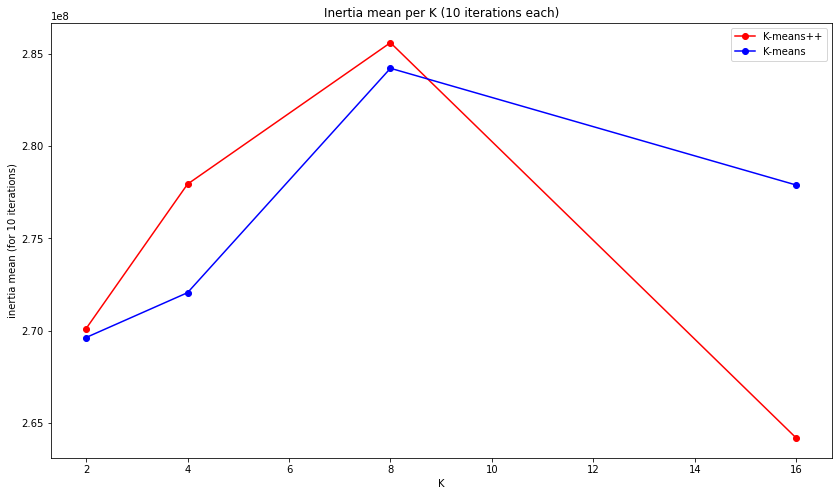

In [29]:
plt.plot(np.array ([2,4,8,16]), inertias_mean_kmeans_pp, label='K-means++', marker = 'o', color='red')
plt.plot(np.array ([2,4,8,16]), inertias_mean_kmeans, marker = 'o', label='K-means', color='blue')
plt.xlabel('K')
plt.ylabel('inertia mean (for 10 iterations)')
plt.title("Inertia mean per K (10 iterations each)")
plt.legend()
plt.show()